In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, SeparableConv2D, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os

2023-05-04 16:11:21.181040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 16:11:22.395530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-04 16:11:22.395664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-04 16:11:22.395670: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [3]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [4]:
crop_size = 300
upscale_factor = 2
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


2023-05-04 16:11:26.753202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 16:11:26.835984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 16:11:26.836159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 16:11:26.836629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [6]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [7]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


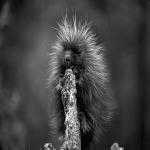

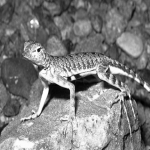

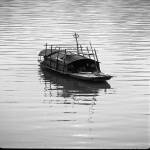

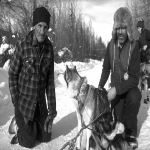

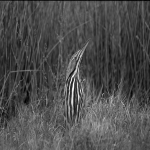

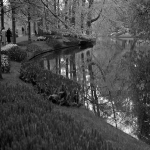

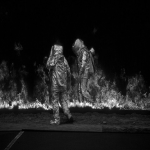

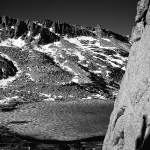

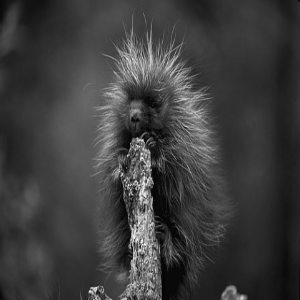

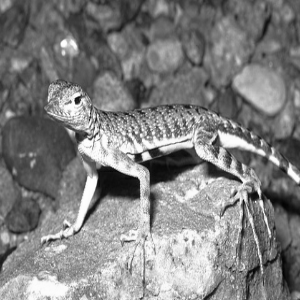

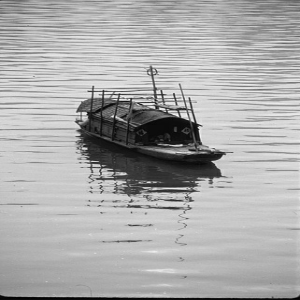

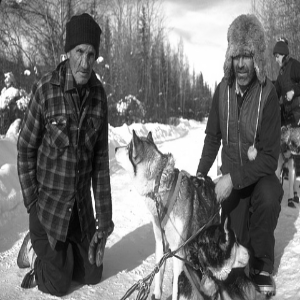

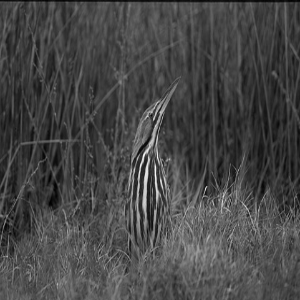

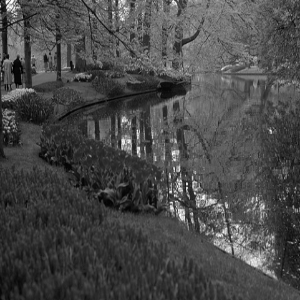

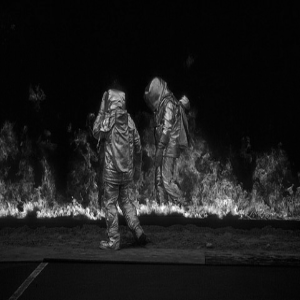

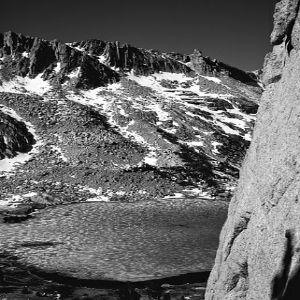

In [8]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [9]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = Input(shape=(None, None, channels))
    x = SeparableConv2D(64, 5, **conv_args)(inputs)
    x = SeparableConv2D(64, 3, **conv_args)(x)
    x = SeparableConv2D(32, 3, **conv_args)(x)
    x = SeparableConv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return Model(inputs, outputs)

In [10]:
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./checkpoints"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 separable_conv2d (Separable  (None, None, None, 64)   153       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, None, None, 64)   4736      
 leConv2D)                                                       
                                                                 
 separable_conv2d_2 (Separab  (None, None, None, 32)   2656      
 leConv2D)                                                       
                                                                 
 separable_conv2d_3 (Separab  (None, None, None, 4)    420       
 leConv2D)                                                   

In [13]:
epochs = 100

# model.compile(
#     optimizer=optimizer, loss=loss_fn,
# )

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)


Epoch 1/100
50/50 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 26ms/step
Epoch 2/100
50/50 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 28ms/step
Epoch 3/100
50/50 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 25ms/step
Epoch 4/100
50/50 - 2s - loss: 0.0017 - val_loss: 0.0015 - 2s/epoch - 38ms/step
Epoch 5/100
50/50 - 3s - loss: 0.0017 - val_loss: 0.0015 - 3s/epoch - 50ms/step
Epoch 6/100
50/50 - 3s - loss: 0.0017 - val_loss: 0.0015 - 3s/epoch - 54ms/step
Epoch 7/100
50/50 - 3s - loss: 0.0017 - val_loss: 0.0015 - 3s/epoch - 55ms/step
Epoch 8/100
50/50 - 3s - loss: 0.0017 - val_loss: 0.0015 - 3s/epoch - 50ms/step
Epoch 9/100
50/50 - 2s - loss: 0.0017 - val_loss: 0.0015 - 2s/epoch - 43ms/step
Epoch 10/100
50/50 - 3s - loss: 0.0017 - val_loss: 0.0015 - 3s/epoch - 51ms/step
Epoch 11/100
50/50 - 1s - loss: 0.0017 - val_loss: 0.0015 - 1s/epoch - 29ms/step
Epoch 12/100
50/50 - 2s - loss: 0.0017 - val_loss: 0.0015 - 2s/epoch - 44ms/step
Epoch 13/100
50/50 - 2s - loss: 0.001

In [15]:
model.save("./models/ESPCNv1_2x")

INFO:tensorflow:Assets written to: ./models/ESPCNv1_2x/assets


INFO:tensorflow:Assets written to: ./models/ESPCNv1_2x/assets
